# SKN 19기 mini-project 5팀(팀명: 여권어디있지) M/L

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# pandas 출력 옵션
pd.set_option('display.float_format', '{:.2f}'.format)


# 한글 폰트 사용을 위한 설정
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [269]:
# 다른 평가 지표
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# 회귀를 평가하는 함수
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true,y_pred)
    rmse = root_mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}')

In [270]:
df_listings = pd.read_csv('./data/listings_cleaned_1st.csv')
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23007 entries, 0 to 23006
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   neighbourhood_cleansed      23007 non-null  object 
 1   property_type               23007 non-null  object 
 2   room_type                   23007 non-null  object 
 3   accommodates                23007 non-null  int64  
 4   bathrooms                   23007 non-null  float64
 5   bedrooms                    23007 non-null  float64
 6   beds                        23007 non-null  float64
 7   price                       23007 non-null  float64
 8   number_of_reviews           23007 non-null  int64  
 9   first_review                19875 non-null  object 
 10  review_scores_rating        19875 non-null  float64
 11  amnt_self_checkin           23007 non-null  int64  
 12  amnt_instant_book           23007 non-null  int64  
 13  amnt_kitchen                230

In [271]:
df_listings.head(5)

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,first_review,...,amnt_ev_charger,amnt_crib,amnt_king_bed,amnt_gym,amnt_breakfast,amnt_fireplace,amnt_smoking_allowed,amnt_waterfront,amnt_smoke_alarm,amnt_carbon_monoxide_alarm
0,Bunkyo Ku,Entire rental unit,Entire home/apt,3,1.00,0.00,2.00,100000.00,0,NaN,...,0,0,0,0,0,1,0,0,1,0
1,Bunkyo Ku,Entire rental unit,Entire home/apt,8,1.00,2.00,5.00,100000.00,0,NaN,...,0,0,0,0,0,1,0,0,1,0
2,Taito Ku,Entire serviced apartment,Entire home/apt,4,2.00,2.00,2.00,14550.00,24,2023-12-04,...,0,0,0,0,0,0,0,0,1,1
3,Kita Ku,Entire home,Entire home/apt,8,1.00,3.00,6.00,22012.00,15,2024-01-10,...,0,0,0,0,0,0,0,0,1,1
4,Sumida Ku,Entire rental unit,Entire home/apt,3,1.00,1.00,1.00,15429.00,17,2023-12-26,...,0,1,0,0,0,1,0,0,1,1


In [272]:
# 6. 데이터 변환 및 피처 엔지니어링

In [273]:
from sklearn.preprocessing import LabelEncoder

le_neighbourhood_cleansed = LabelEncoder()
le_property_type = LabelEncoder()
le_room_type = LabelEncoder()

df_listings["neighbourhood_cleansed"] = le_neighbourhood_cleansed.fit_transform(df_listings["neighbourhood_cleansed"])
df_listings["property_type"] = le_property_type.fit_transform(df_listings["property_type"])
df_listings["room_type"] = le_room_type.fit_transform(df_listings["room_type"])

# 

df_listings['first_review'] = pd.to_datetime(df_listings['first_review'], errors='coerce')

reference_date = pd.to_datetime('2025-06-27')
df_listings['days_since_first_review'] = (reference_date - df_listings['first_review']).dt.days


# 드롭 목록
drop_list = [
    'number_of_reviews',    # 리뷰 갯수
    'first_review',          # 첫 리뷰 일자
    'first_review'
    # 'review_scores_rating'
]

df_listings = df_listings.drop(drop_list, axis=1)


In [274]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import optuna

def print_optimized_hyper_params(X, y):

    def lgbm_optuna_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }

        lgbm_reg = LGBMRegressor(**params, n_jobs=-1)
        mean_r2 = cross_val_score(lgbm_reg, X, y, scoring='r2', cv=3).mean()
        return mean_r2
    # 2. study 객체 -> 최적화
    study = optuna.create_study(direction="maximize")
    study.optimize(lgbm_optuna_objective, n_trials=100)
    # 3. 결과 출력
    print(study.best_value)
    print(study.best_params)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate


lgbm_reg = LGBMRegressor(n_estimators=500,  # 트리의 개수
                         max_depth=9,
                         learning_rate=0.11, # 학습률
                        #  random_state=42,
                         colsample_bytree=0.68,
                         force_row_wise=True, 
                         n_jobs=-1) # 모든 코어 사용




x = df_listings.drop('price', axis=1)
y = df_listings['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

y_train = np.log(y_train)
y_test = np.log(y_test)


scores = cross_val_score(lgbm_reg, X_train, y_train, cv=5, scoring='r2')

print("훈련별 정확도:", scores)
print("모델 정확도:", np.mean(scores))




[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 14724, number of used features: 33
[LightGBM] [Info] Start training from score 9.588749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data point

In [ ]:
lgbm_reg.fit(X_train, y_train)
y_pred_test = lgbm_reg.predict(X_test)
y_pred_train = lgbm_reg.predict(X_train)

In [ ]:
evaluate_regression(y_train,y_pred_train)
evaluate_regression(y_test,y_pred_test)

MSE: 0.061873304043659365, RMSE: 0.24874345025278427, MAE: 0.1846426887245339, R2: 0.8328979665433394
MSE: 0.10545552516209901, RMSE: 0.3247391648109279, MAE: 0.24221607753042626, R2: 0.7186405600187213


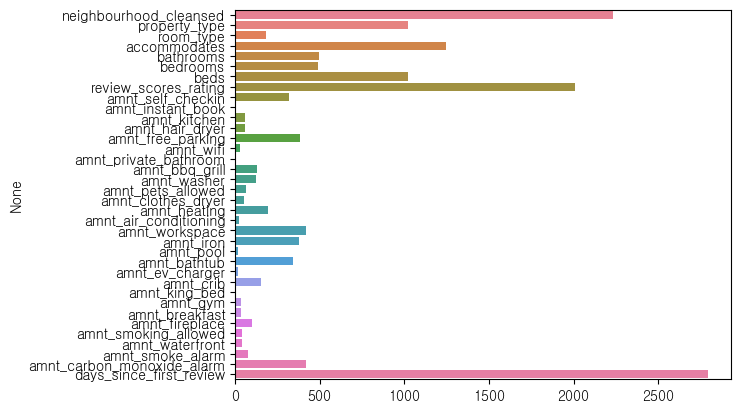

In [ ]:

sns.barplot(x=lgbm_reg.feature_importances_, y=X_train.columns, hue=X_train.columns)
plt.show()